In [27]:
from time import time
from datetime import datetime
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import random, genfromtxt
from IPython.display import display
from matplotlib import rc
from matplotlib.pyplot import figure
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import matplotlib.ticker as mticker
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [28]:
# 设置数据类型
DTYPE = torch.float32

# 设置随机种子
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

df = {}
optionM=0 # 0:训练储存模量；1：训练损耗模量
# 读取数据
# url_lf = 'Oscillatory/Data_LF_AS_Gp.xlsx'
url_hf = 'Oscillatory/Data_HF.xlsx'

# df_LF = pd.read_excel(url_lf, sheet_name=None)
# data_LF = [[k, v] for k, v in df_LF.items()]  # k is the sheet name, v is the pandas df

df_HF = pd.read_excel(url_hf, sheet_name=None)
data_HF = [[k, v] for k, v in df_HF.items()]  # k is the sheet name, v is the pandas df

sample = 0
data_HF[sample][1] = data_HF[sample][1].dropna()
df_hf = data_HF[sample][1]  # entire data
x1_d_HF = torch.tensor(data_HF[sample][1]['DP'].values, dtype=torch.float32).view(-1, 1)
x2_d_HF = torch.tensor(data_HF[sample][1]['Mn'].values, dtype=torch.float32).view(-1, 1)
x3_d_HF = torch.tensor(data_HF[sample][1]['PDI'].values, dtype=torch.float32).view(-1, 1)
x4_d_HF = torch.tensor(data_HF[sample][1]['AngFreq'].values, dtype=torch.float32).view(-1, 1)
y1_d_HF = torch.tensor(data_HF[sample][1]['StorageM'].values, dtype=torch.float32).view(-1, 1)
y2_d_HF = torch.tensor(data_HF[sample][1]['LossM'].values, dtype=torch.float32).view(-1, 1)

# 对 HF 数据进行对数变换
x4_d_HF = torch.log10(x4_d_HF) # 频率对数化
y1_d_HF = torch.log10(y1_d_HF) # 储存模量对数化
y2_d_HF = torch.log10(y2_d_HF) # 损耗模量对数化
# 计算边界
x1min, x1max = torch.min(x1_d_HF), torch.max(x1_d_HF)
x2min, x2max = torch.min(x2_d_HF), torch.max(x2_d_HF)
x3min, x3max = torch.min(x3_d_HF), torch.max(x3_d_HF)
x4min, x4max = torch.min(x4_d_HF), torch.max(x4_d_HF)
y1min, y1max = torch.min(y1_d_HF), torch.max(y1_d_HF)
y2min, y2max = torch.min(y2_d_HF), torch.max(y2_d_HF)
# 3,4,5为对数化
lb = torch.tensor([x1min, x2min, x3min, x4min,y1min,y2min], dtype=torch.float32).numpy()
ub = torch.tensor([x1max, x2max, x3max, x4max,y1max,y2max], dtype=torch.float32).numpy()
# 归一化函数
def norm(vectors, lb, ub):
    normalized_vectors = (vectors - lb) / (ub - lb)
    return normalized_vectors
# TODO 定义绘图的测试集,这里应该是test，valid是复制另一份代码，有空改
data_valid=df_hf[df_hf.DP == 162.]

x1_d_valid = torch.tensor(data_valid['DP'].values, dtype=torch.float32).view(-1, 1)
x2_d_valid = torch.tensor(data_valid['Mn'].values, dtype=torch.float32).view(-1, 1)
x3_d_valid = torch.tensor(data_valid['PDI'].values, dtype=torch.float32).view(-1, 1)
x4_d_valid = torch.tensor(data_valid['AngFreq'].values, dtype=torch.float32).view(-1, 1)
y1_d_valid = torch.tensor(data_valid['StorageM'].values, dtype=torch.float32).view(-1, 1)
y2_d_valid = torch.tensor(data_valid['LossM'].values, dtype=torch.float32).view(-1, 1)

# 对 HF 数据进行对数变换
x4_d_valid = torch.log10(x4_d_valid) # 频率对数化
y1_d_valid = torch.log10(y1_d_valid) # 储存模量对数化
y2_d_valid = torch.log10(y2_d_valid) # 损耗模量对数化

x1_d_valid = norm(x1_d_valid, lb[0], ub[0])
x2_d_valid = norm(x2_d_valid, lb[1], ub[1])
x3_d_valid = norm(x3_d_valid, lb[2], ub[2])
x4_d_valid = norm(x4_d_valid, lb[3], ub[3])
y1_d_valid = norm(y1_d_valid, lb[4], ub[4])
y2_d_valid = norm(y2_d_valid, lb[5], ub[5])

# 合并数据
X_data_valid = torch.cat([x1_d_valid, x2_d_valid, x3_d_valid,x4_d_valid], dim=1)
y_data_valid= torch.cat([y1_d_valid], dim=1) # 储存模量
# 定义模型
in_dim, out_dim = 4, 1

In [29]:
# 神经网络的类
class PINN_NeuralNet(nn.Module):
    """ Set basic architecture of the PINN model."""

    def __init__(self,
                 input_dim=0,
                 output_dim=1,  # 默认输出维度为1
                 num_hidden_layers=4, 
                 num_neurons_per_layer=20,
                 activation='tanh',
                 kernel_initializer='glorot_normal',
                 **kwargs):
        super(PINN_NeuralNet, self).__init__()

        self.num_hidden_layers = num_hidden_layers
        self.output_dim = output_dim
        
        # 添加输入层
        self.input_layer = nn.Linear(input_dim, num_neurons_per_layer)
        
        # 添加其他隐藏层
        self.hidden_layers = nn.ModuleList()
        for _ in range(num_hidden_layers):
            self.hidden_layers.append(nn.Linear(num_neurons_per_layer, num_neurons_per_layer))
        
        # 添加输出层
        self.out = nn.Linear(num_neurons_per_layer, output_dim)
        # 设置激活函数
        if activation == 'tanh':
            self.activation = torch.tanh
        elif activation == 'relu':
            self.activation = F.relu6
        elif activation == 'sigmoid':
            self.activation = torch.sigmoid
        elif activation == 'linear':
            self.activation = None
        else:
            raise ValueError("Unsupported activation function")
        
        # 初始化权重
        if kernel_initializer == 'glorot_normal':
            nn.init.xavier_normal_(self.input_layer.weight)
            for hidden_layer in self.hidden_layers:
                nn.init.xavier_normal_(hidden_layer.weight)
            nn.init.xavier_normal_(self.out.weight)
        elif kernel_initializer == 'glorot_uniform':
            nn.init.xavier_uniform_(self.input_layer.weight)
            for hidden_layer in self.hidden_layers:
                nn.init.xavier_uniform_(hidden_layer.weight)
            nn.init.xavier_uniform_(self.out.weight)
        else:
            raise ValueError("Unsupported kernel initializer")

    def forward(self, X):

        # 进入输入层
        Z = self.input_layer(X)
        
        # 通过隐藏层
        for hidden_layer in self.hidden_layers:
            Z = hidden_layer(Z)
            if self.activation is not None:
                Z = self.activation(Z)
        # 通过输出层输出
        Z = self.out(Z)
        
        return Z

In [30]:
model_HF_nl_pinn = PINN_NeuralNet(input_dim=in_dim,
                             output_dim=out_dim,
                             num_hidden_layers=4,
                             num_neurons_per_layer=64,
                             activation='relu')
model_HF_l_pinn = PINN_NeuralNet(input_dim=in_dim,
                            output_dim=out_dim,
                            num_hidden_layers=1,
                            num_neurons_per_layer=10,
                            activation='linear')
model_HF_nl_dnn = PINN_NeuralNet(input_dim=in_dim,
                             output_dim=out_dim,
                             num_hidden_layers=4,
                             num_neurons_per_layer=64,
                             activation='relu')
model_HF_l_dnn = PINN_NeuralNet(input_dim=in_dim,
                            output_dim=out_dim,
                            num_hidden_layers=1,
                            num_neurons_per_layer=10,
                            activation='linear')


## 绘制strorgeM

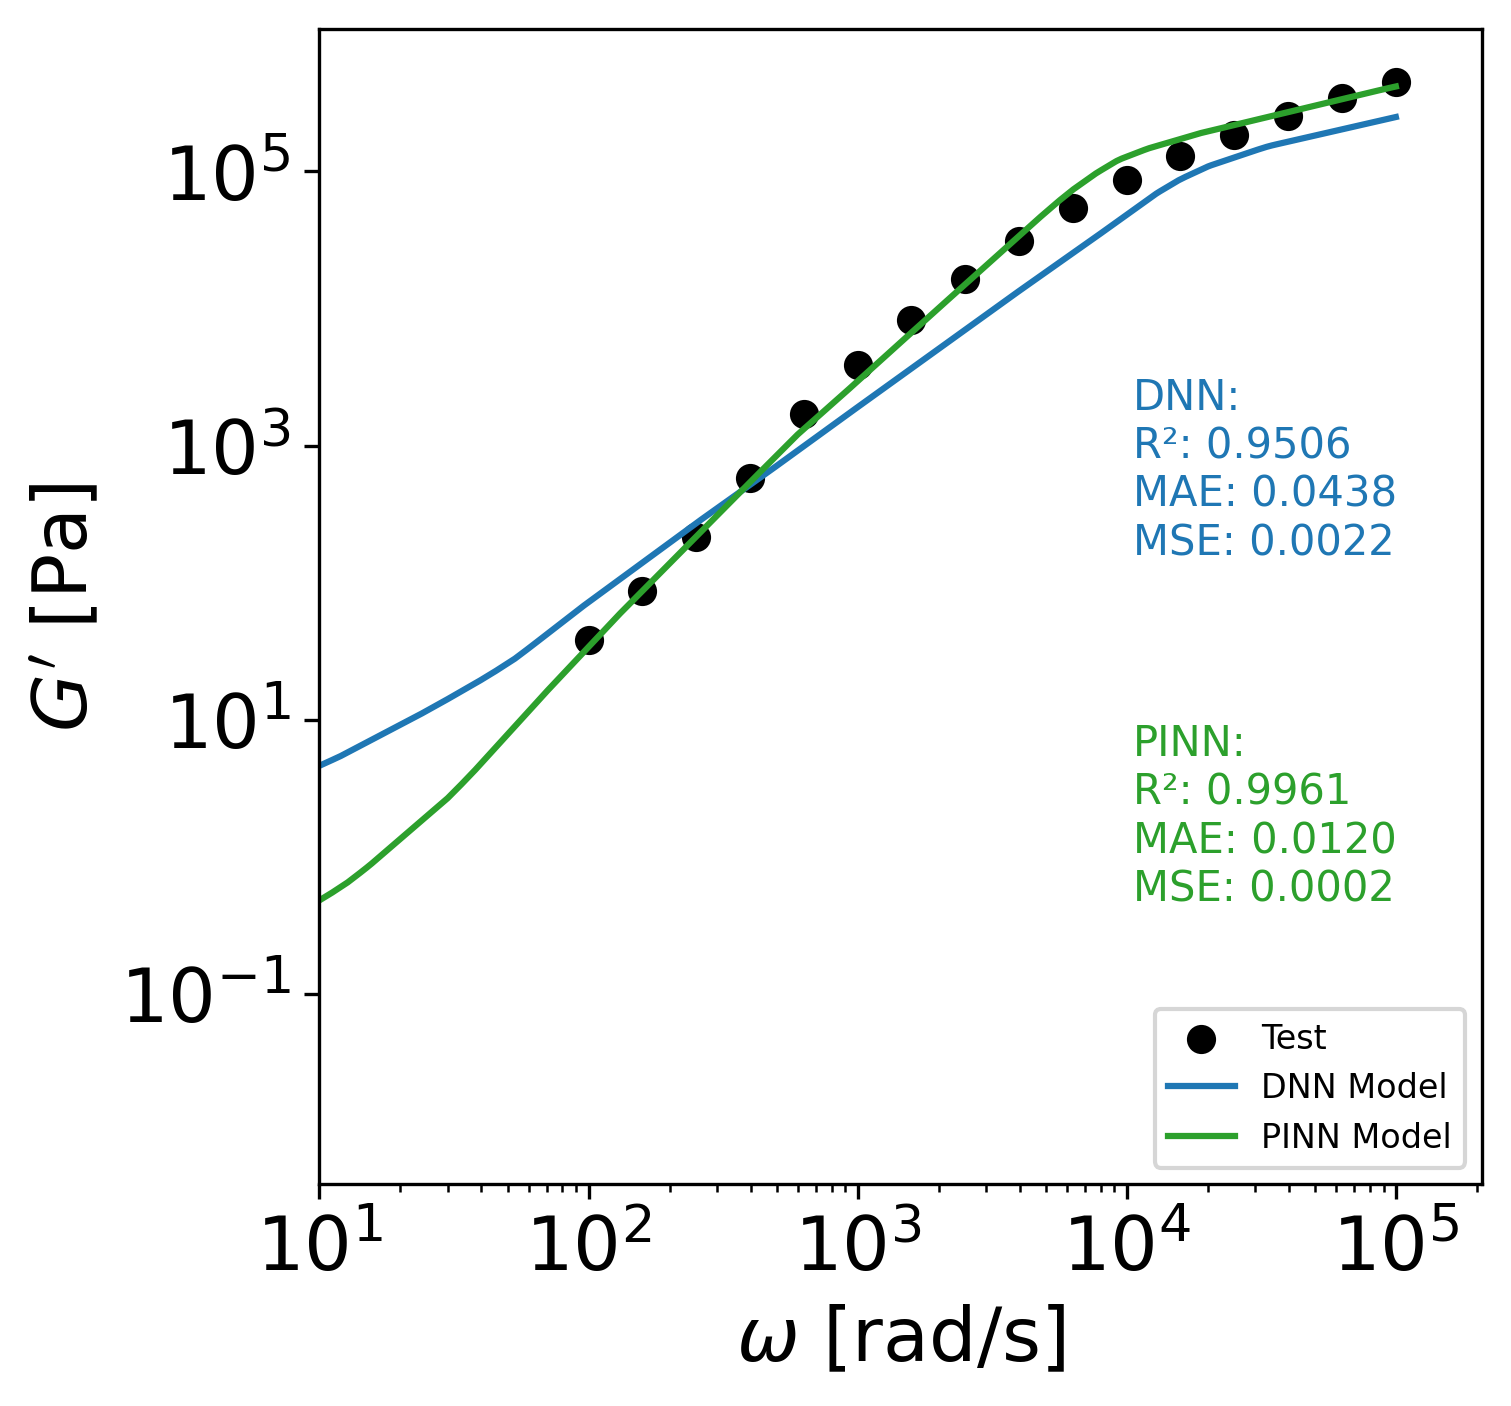

In [32]:
# 加载模型权重
model_HF_nl_dnn.load_state_dict(torch.load('model_nl_dnn.pth'))
model_HF_l_dnn.load_state_dict(torch.load('model_l_dnn.pth'))
model_HF_nl_pinn.load_state_dict(torch.load('model_nl_pinn.pth'))
model_HF_l_pinn.load_state_dict(torch.load('model_l_pinn.pth'))

# 设置绘图参数
plt.rc('font', size=18)
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rc('figure', titlesize=18)
colors = ['tab:red', 'tab:orange', '#f9c74f', 'tab:green', 'tab:cyan', 'tab:blue', 'tab:purple', 'tab:brown', 'tab:pink']

fig, ax = plt.subplots(figsize=(5, 5), dpi=300)

def denorm(normalized_vectors, lb, ub):
    original_vectors = normalized_vectors * (ub - lb) + lb
    return original_vectors

# 绘制模型曲线图，同时返回模型在测试集上的指标
def plot_curves(model_HF_nl, model_HF_l, color, label, ax, test_data, lb, ub):
    N_exp = 1000
    w_plot = np.linspace(lb[3], ub[3], N_exp).reshape(-1, 1)
    DP_range = [162.]

    for i in range(len(DP_range)):
        DP_plot = norm(DP_range[i] * np.ones(N_exp).reshape(-1, 1), lb[0], ub[0])
        Mn_plot = norm(np.unique(test_data['Mn']) * np.ones(N_exp).reshape(-1, 1), lb[1], ub[1])
        PDI_plot = norm(np.unique(test_data['PDI']) * np.ones(N_exp).reshape(-1, 1), lb[2], ub[2])

        X_MF_np = np.hstack((DP_plot, Mn_plot, PDI_plot, norm(w_plot, lb[3], ub[3])))
        X_MF = torch.tensor(X_MF_np, dtype=torch.float32)
        y_MF = model_HF_nl(X_MF) + model_HF_l(X_MF)
        
        y_MF_denorm = denorm(y_MF.detach().numpy(), lb[4], ub[4])

        ax.plot(10 ** w_plot, 10 ** y_MF_denorm, color=color, label=label)

    y_pre=model_HF_l(X_data_valid)+model_HF_nl(X_data_valid)

    R2 = r2_score(y_pre.detach().numpy(), y1_d_valid)
    MAE = mean_absolute_error(y_pre.detach().numpy(), y1_d_valid)
    MSE = mean_squared_error(y_pre.detach().numpy(), y1_d_valid)
    return [R2,MAE,MSE]   

# 获取测试数据
DP_range = [162.]
test_data = df_hf[df_hf.DP == DP_range[0]]
x1_test = test_data['AngFreq'].values  # 未对数化、未归一化, np
y1_test = test_data['StorageM'].values  # 未对数化，未归一化, np

# 绘制测试点
ax.scatter(x1_test, y1_test, color='black', marker='o', label='Test')

# 绘制DNN模型曲线
metric_dnn=plot_curves(model_HF_nl_dnn, model_HF_l_dnn, 'tab:blue', 'DNN Model', ax, test_data, lb, ub)

# 绘制PINN模型曲线
metric_pinn=plot_curves(model_HF_nl_pinn, model_HF_l_pinn, 'tab:green', 'PINN Model', ax, test_data, lb, ub)
# 打印指标到图中
ax.text(0.7, 0.7, f'DNN:\nR²: {metric_dnn[0]:.4f}\nMAE: {metric_dnn[1]:.4f}\nMSE: {metric_dnn[2]:.4f}', 
        transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=None,color='tab:blue')
ax.text(0.7, 0.4, f'PINN:\nR²: {metric_pinn[0]:.4f}\nMAE: {metric_pinn[1]:.4f}\nMSE: {metric_pinn[2]:.4f}', 
        transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=None,color='tab:green')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('$G\'$ $\mathrm{[Pa]}$')
ax.set_xlabel('$\omega$ $\mathrm{[rad/s]}$')
ax.legend(fontsize=8, loc='lower right', bbox_to_anchor=(1, 0))
ax.set_xlim(10,)
plt.show()

## 绘制lossM

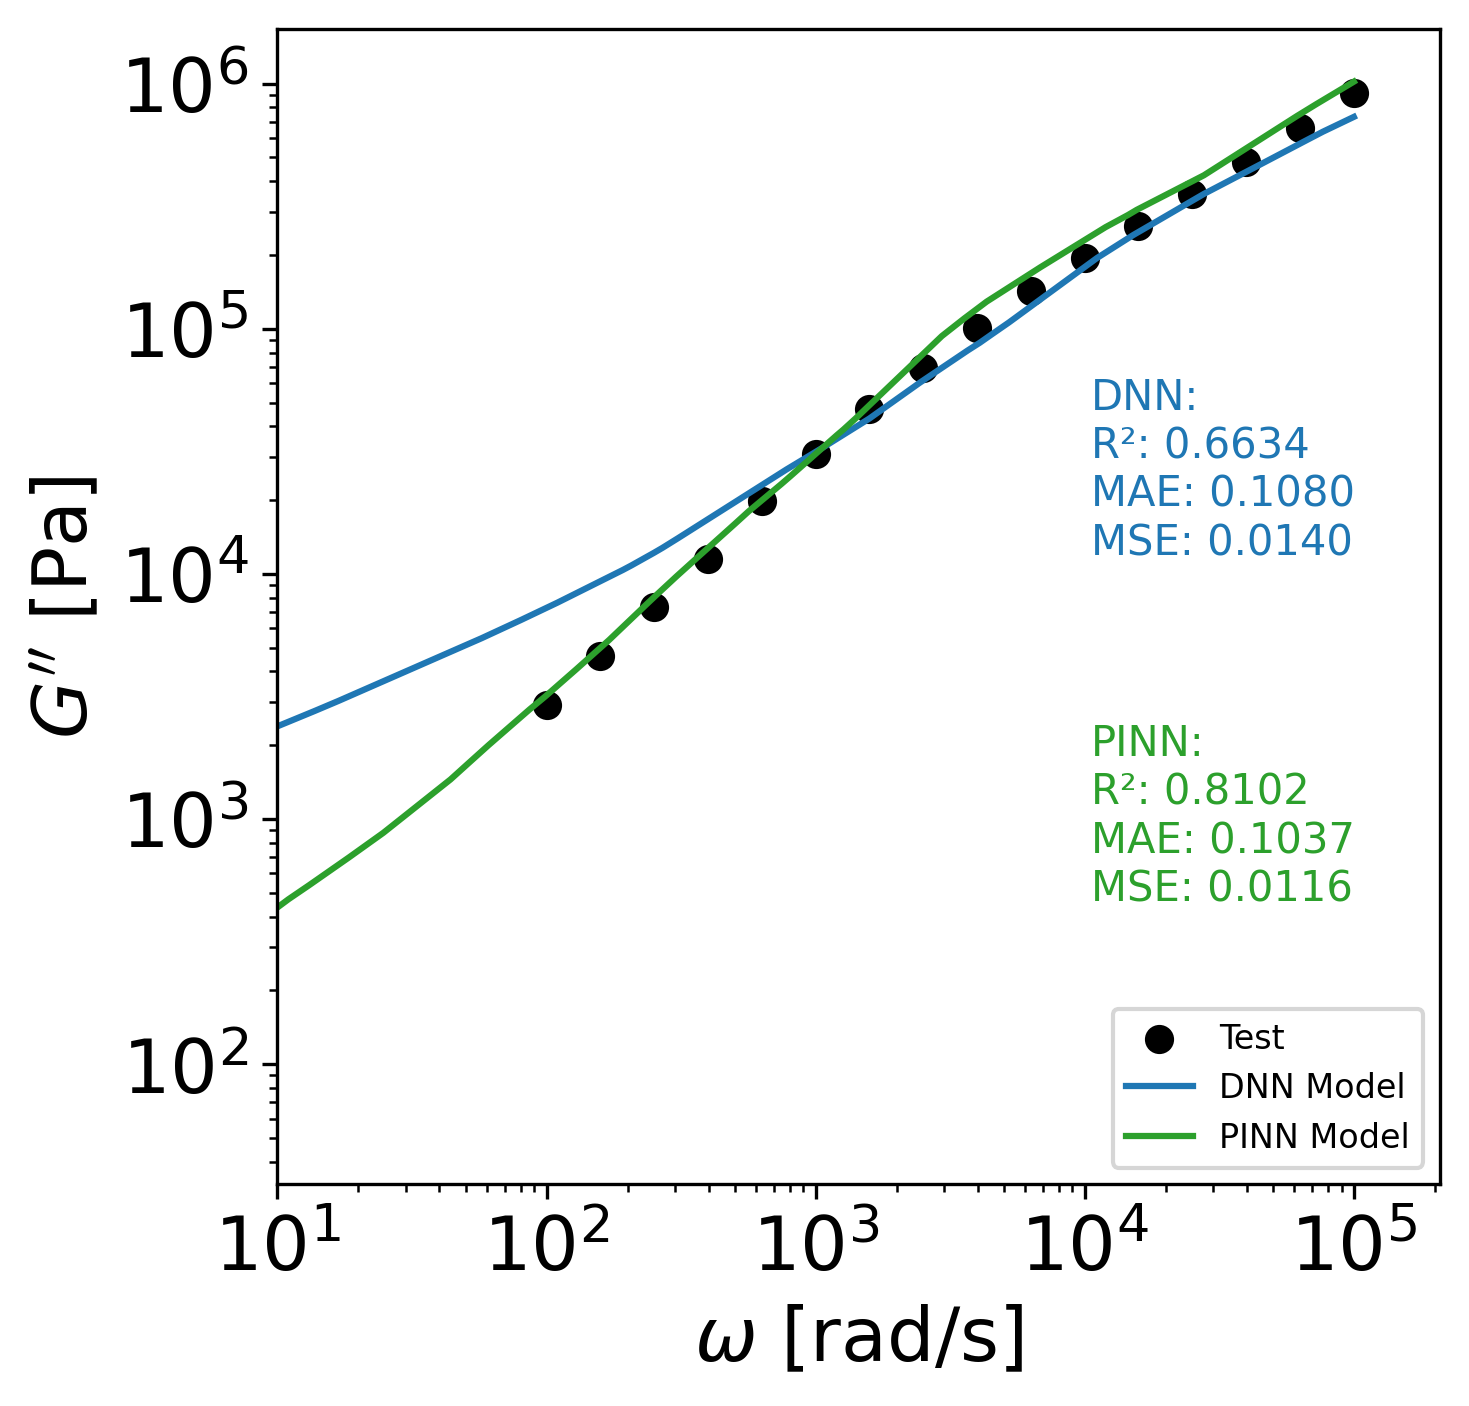

In [34]:
# 加载模型权重
model_HF_nl_dnn.load_state_dict(torch.load('model_nl_dnn_lossm.pth'))
model_HF_l_dnn.load_state_dict(torch.load('model_l_dnn_lossm.pth'))
model_HF_nl_pinn.load_state_dict(torch.load('model_nl_pinn_lossm.pth'))
model_HF_l_pinn.load_state_dict(torch.load('model_l_pinn_lossm.pth'))

# 设置绘图参数
plt.rc('font', size=18)
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rc('figure', titlesize=18)
colors = ['tab:red', 'tab:orange', '#f9c74f', 'tab:green', 'tab:cyan', 'tab:blue', 'tab:purple', 'tab:brown', 'tab:pink']

fig, ax = plt.subplots(figsize=(5, 5), dpi=300)

def denorm(normalized_vectors, lb, ub):
    original_vectors = normalized_vectors * (ub - lb) + lb
    return original_vectors

# 获取测试数据
DP_range = [162.]
test_data = df_hf[df_hf.DP == DP_range[0]]
x1_test = test_data['AngFreq'].values  # 未对数化、未归一化, np
y1_test = test_data['LossM'].values  # 未对数化，未归一化, np


y_data_valid= torch.cat([y2_d_valid], dim=1) # 修改为损耗模量
# 绘制模型曲线图，同时返回模型在测试集上的指标
def plot_curves(model_HF_nl, model_HF_l, color, label, ax, test_data, lb, ub):
    N_exp = 1000
    w_plot = np.linspace(lb[3], ub[3], N_exp).reshape(-1, 1)
    DP_range = [162.]

    for i in range(len(DP_range)):
        DP_plot = norm(DP_range[i] * np.ones(N_exp).reshape(-1, 1), lb[0], ub[0])
        Mn_plot = norm(np.unique(test_data['Mn']) * np.ones(N_exp).reshape(-1, 1), lb[1], ub[1])
        PDI_plot = norm(np.unique(test_data['PDI']) * np.ones(N_exp).reshape(-1, 1), lb[2], ub[2])

        X_MF_np = np.hstack((DP_plot, Mn_plot, PDI_plot, norm(w_plot, lb[3], ub[3])))
        X_MF = torch.tensor(X_MF_np, dtype=torch.float32)
        y_MF = model_HF_nl(X_MF) + model_HF_l(X_MF)
        
        y_MF_denorm = denorm(y_MF.detach().numpy(), lb[5], ub[5])

        ax.plot(10 ** w_plot, 10 ** y_MF_denorm, color=color, label=label)

    y_pre=model_HF_l(X_data_valid)+model_HF_nl(X_data_valid)
    # 计算模型的指标
    R2 = r2_score(y_pre.detach().numpy(), y1_d_valid)
    MAE = mean_absolute_error(y_pre.detach().numpy(), y1_d_valid)
    MSE = mean_squared_error(y_pre.detach().numpy(), y1_d_valid)
    return [R2,MAE,MSE]   


# 绘制测试点
ax.scatter(x1_test, y1_test, color='black', marker='o', label='Test')

# 绘制DNN模型曲线
metric_dnn=plot_curves(model_HF_nl_dnn, model_HF_l_dnn, 'tab:blue', 'DNN Model', ax, test_data, lb, ub)

# 绘制PINN模型曲线
metric_pinn=plot_curves(model_HF_nl_pinn, model_HF_l_pinn, 'tab:green', 'PINN Model', ax, test_data, lb, ub)
# 打印指标到图中
ax.text(0.7, 0.7, f'DNN:\nR²: {metric_dnn[0]:.4f}\nMAE: {metric_dnn[1]:.4f}\nMSE: {metric_dnn[2]:.4f}', 
        transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=None,color='tab:blue')
ax.text(0.7, 0.4, f'PINN:\nR²: {metric_pinn[0]:.4f}\nMAE: {metric_pinn[1]:.4f}\nMSE: {metric_pinn[2]:.4f}', 
        transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=None,color='tab:green')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('$G\'\'$ $\mathrm{[Pa]}$')
ax.set_xlabel('$\omega$ $\mathrm{[rad/s]}$')
ax.legend(fontsize=8, loc='lower right', bbox_to_anchor=(1, 0))
ax.set_xlim(10,)
plt.show()